<a href="https://colab.research.google.com/github/wdwzyyg/Atom-Finder/blob/main/Simu_Datapre%26collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import module

In [ ]:
import scipy
import scipy.fftpack as syfp
from scipy import ndimage as ndi
from scipy import optimize
from skimage.feature import peak_local_max
from skimage.morphology import local_maxima
from pylab import *
from PIL import Image
import glob
import os 
import sys
import math
import numpy as np

import matplotlib.pyplot as plt
import scipy.io as scio

import copy
import subprocess
from collections import OrderedDict
import matplotlib.patches as patches
from scipy import fftpack, ndimage, optimize, spatial, stats
from skimage import exposure
from skimage.util import random_noise
from sklearn.feature_extraction.image import extract_patches_2d
#from sklearn.preprocessing import OneHotEncode

import h5py
import tarfile
import cv2

from scipy.io import loadmat
def map01(mat):
    return (mat - mat.min())/(mat.max() - mat.min())

#### Posprocessing on Prismatic result

In [ ]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def check_finish(datadirc, pos):
    # navigate to the 4D data npy arrays and check simulation state
    f = h5py.File(datadirc, 'r')
    a = f['4DSTEM_simulation']
    b = a['data']
    c = b['datacubes']
    d = c['CBED_array_depth0000']
    e = d['datacube']
    plt.imshow(e[:,:,pos,pos], origin = "lower")

In [ ]:
# navigate to the 4D data npy arrays and show dimention
f = h5py.File('/content/drive/My Drive/Prismatic/WS2-2H/WS2_2H_Attemp2', 'r')
a = f['4DSTEM_simulation']
b = a['data']
c = b['realslices']
print(c.keys())
#d = c['annular_detector_depth0001']
#e = d['realslice']
#plt.imshow(e)

<KeysViewHDF5 ['ppotential']>


In [ ]:
b.keys()

<KeysViewHDF5 ['datacubes', 'diffractionslices', 'pointlistarrays', 'pointlists', 'realslices']>

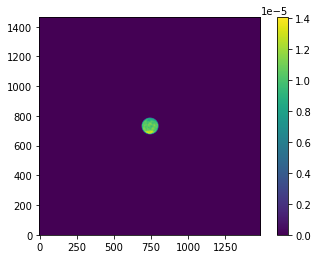

(29, 29, 1464, 1488)

In [ ]:
#show one CBED of new Prismatic
c = b['datacubes']
d = c['CBED_array_depth0001']
e = d['datacube']
plt.imshow(e[2,0], origin = "lower")
plt.colorbar()
plt.show()
e.shape

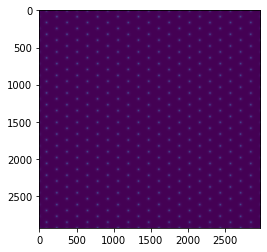

In [ ]:

# check ppotential

g = b['realslices']
potential = g['ppotential']
real = potential['realslice']
real.shape
plt.imshow(real[:,:,3])

#### Read result from Creatphatom

first use the Creatphatom code matlab code to generate px size series

In [ ]:
## Crop truth image

path = '/content/drive/MyDrive/AtomfinderProject/Data/Diffdistortion/randomdrift/0.17R0.5F/0.02R2.5F_Truth.png'
truth  = Image.open(path)
truth = np.asarray(truth)
small = truth[45:301,45:301] # for 346
#small = truth[41:297,41:297] # for 338
#small = truth[42:298,42:298] # for 340
im = Image.fromarray(small, 'L')
im.save('/content/drive/MyDrive/AtomfinderProject/Data/Diffdistortion/randomdrift/0.16R0.5F - Copy/0.02R2.5F_Truth.tif')
os.remove(path)

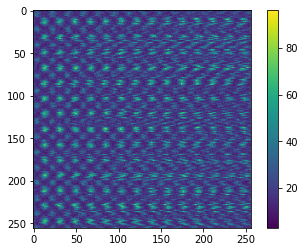

In [ ]:
# Read mat file
from scipy.io import loadmat
immat = loadmat('/content/drive/MyDrive/AtomfinderProject/Data/Diffdistortion/randomdrift/0.17R0.5F/0.02R2.5F_000.mat')
#framenoise = immat['frame_noise']
framenoise = immat['frame_noise']
plt.imshow(framenoise)
plt.colorbar()

Contrast: 0.6041666666666666 max 96.0


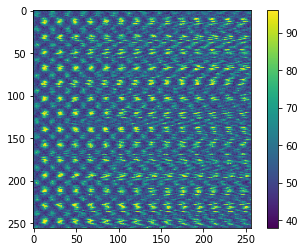

In [ ]:
# change contrast by add background 
# try to control the contrast at constant value: 0.6
factor = 35
background = factor*np.ones((256, 256))
new = np.clip(background+framenoise, a_min = 0, a_max = framenoise.max())
contrast = (new.max()-new.min())/new.max()
plt.imshow(new)
plt.colorbar()
print("Contrast:",contrast,'max',framenoise.max())  

In [ ]:
new = np.array(new, dtype='float64')
np.save('/content/drive/MyDrive/AtomfinderProject/Data/Diffdistortion/randomdrift/0.17R0.5F/0.02R2.5F_000.npy',new)
new = (map01(new) * 255).astype('uint8')
im = Image.fromarray(new, 'L')
im.save('/content/drive/MyDrive/AtomfinderProject/Data/Diffdistortion/randomdrift/0.17R0.5F/0.02R2.5F_000.tif')

#### Find ground truth

First find all the atom peaks as ground truth

then limit the threshold to find only the atoms that you want to calculate precision from, called UnaryPeaks_x/y

(256, 256)
Coordinate:  (784, 2)
Coordinate now:  (392, 2)


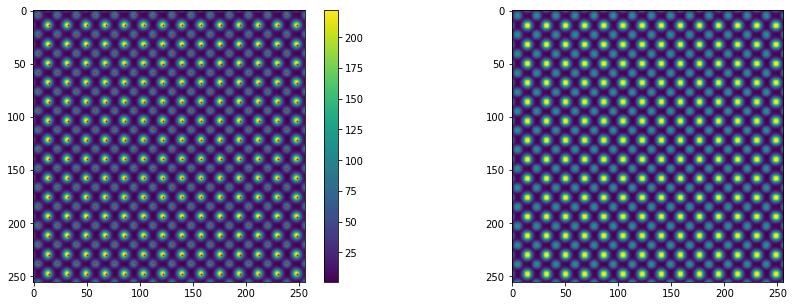

In [ ]:
path = '/content/drive/MyDrive/AtomfinderProject/Data/Diffdistortion/randomdrift/0.16R0.5F - Copy/0.02R2.5F_Truth.tif'
#os.chdir(path)
im = Image.open(path)
im = np.asarray(im)
print(im.shape)

#immat = loadmat('/content/drive/MyDrive/AtomfinderProject/Data/DiffContrast/simulate/direct/px22d7pm_000.mat')
#im = immat['frame_noise']
#im = np.asarray(im)
image_max = ndi.maximum_filter(im, size =2, mode = 'constant')
imgaussian = ndi.gaussian_filter(im, sigma = 1)


coordinates = peak_local_max(imgaussian, min_distance = 4, threshold_abs = 0) 
print('Coordinate: ',coordinates.shape)


# the peak_local_max give multiple coordinates with same intensity at flat peak, so try to get rid of them here
co_tempt = coordinates
del_index = []
for i in range(coordinates.shape[0]):
  for j in range(i+1, coordinates.shape[0]):
    dis = math.sqrt((coordinates[i][0]- coordinates[j][0])**2 + (coordinates[i][1] - coordinates[j][1])**2)
###
    if (dis < 5) & (dis > 0):
      del_index.append(j)
coordinates = np.delete(coordinates,del_index,0)
print('Coordinate now: ', coordinates.shape)

fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
plt.imshow(imgaussian)
plt.colorbar()
plt.scatter(np.transpose(coordinates)[1],np.transpose(coordinates)[0],s = 1, c = 'r')

fig.add_subplot(122)
plt.imshow(image_max)

(338,) float64


"plt.scatter(np.transpose(coordinates)[1],np.transpose(coordinates)[0],s = 1, c = 'r')"

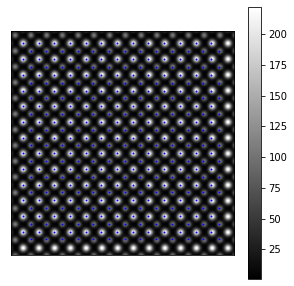

In [ ]:
'''## Get rid of coords in blank area 
del_index = []
for i in range(coordinates.shape[0]):
  if coordinates[i][1]>240:
    del_index.append(i)
coordinates = np.delete(coordinates,del_index,0)
print('Coordinate now: ', coordinates.shape)'''
peak_y_fit, peak_x_fit, edgey, edgex = peakfit(coordinates, imgaussian, path,9)
print(peak_y_fit.shape,peak_y_fit.dtype)
'''plt.scatter(np.transpose(coordinates)[1],np.transpose(coordinates)[0],s = 1, c = 'r')'''

(392,) (392,)


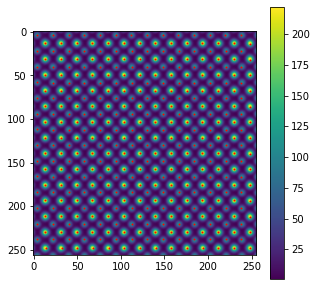

In [ ]:
# Don't use this now. Already tried to delete detected atoms at edge from the models
# combine the unfitted edge points and fitted points

peak_y_fit = np.hstack((peak_y_fit, edgey))
peak_x_fit = np.hstack((peak_x_fit, edgex))
print(peak_y_fit.shape, peak_x_fit.shape)
fig = plt.figure(figsize=(5,5))
plt.imshow(imgaussian)
plt.colorbar()
plt.scatter(peak_x_fit, peak_y_fit, s = 1, c = 'r')

In [ ]:
savepath = '/content/drive/MyDrive/AtomfinderProject/Data/Diffdistortion/randomdrift/0.16R0.5F - Copy/'
np.save(savepath+'Peaks_x.npy', np.asarray(peak_x_fit))
np.save(savepath+'Peaks_y.npy', np.asarray(peak_y_fit))

'''np.save(savepath+'UnaryPeaks_x.npy', np.asarray(peak_x_fit))
np.save(savepath+'UnaryPeaks_y.npy', np.asarray(peak_y_fit))'''

"np.save(savepath+'UnaryPeaks_x.npy', np.asarray(peak_x_fit))\nnp.save(savepath+'UnaryPeaks_y.npy', np.asarray(peak_y_fit))"

138 191
[65.52389429 61.26273528  7.58396871  7.94691735  1.95455405  1.25522692]
7.583968709495492 7.946917345323716
138.58396870949548 191.94691734532373


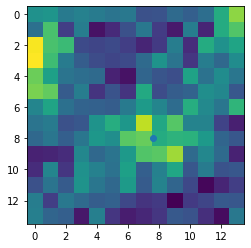

In [ ]:
### Check

x = int(peak_x_fit[111])
y = int(peak_y_fit[111])
print(x,y)
patcha = im[y-7:y+7,x-7:x+7]
plt.imshow(patcha)
bg = np.amin(patcha)
guess = (bg,im[7,7]-bg,7, 7,3, 3)
bounds = ([0,0,0,0,1,1],[np.inf,np.inf,20,20, 18, 18])
param = fitGaussianx2(patcha, guess, bounds)
print(param)
plt.scatter(param[2],param[3])
print(param[2],param[3])
print(param[2]+x-7,param[3]+y-7)

#### Simulated image augmentation

Contrast: 0.4117647058823529 max 255


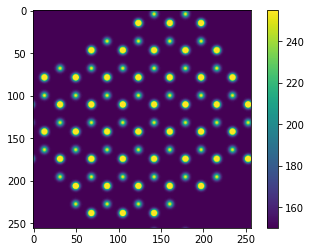

In [ ]:
#Contrast edge test

'''immat = loadmat('/content/drive/My Drive/AtomfinderProject/Data/DiffMag/simulate/px22d7pm/px22d7pm_000.mat')
framenoise = immat['frame_noise']'''
im = Image.open('/content/drive/My Drive/AtomfinderProject/Data/WS2/Simu/origin8d59pm.tif')
framenoise = np.asarray(im)
# change contrast by add background 
factor = 150
background = factor*np.ones((256, 256))
new = np.clip(background+framenoise, a_min = 0, a_max = framenoise.max())
contrast = (new.max()-new.min())/new.max()
plt.imshow(new)
plt.colorbar()
print("Contrast:",contrast,'max',framenoise.max())  

Souce size: 175 pm
Souce size: 180 pm
Souce size: 185 pm
Souce size: 190 pm


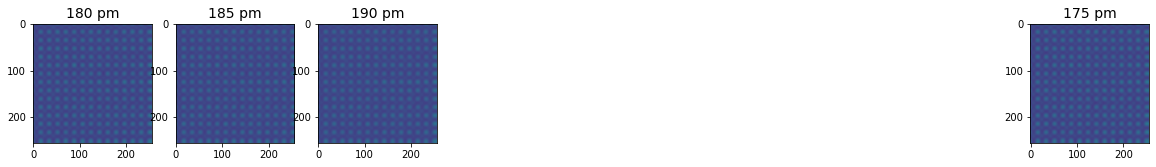

In [ ]:
# pixel size used in both simulation and experiment
px_size = 22.7
immat = loadmat('/content/drive/MyDrive/AtomfinderProject/Data/DiffContrast/simulate/direct/px22d7pm_000.mat')
#framenoise = immat['frame_noise']
HAADF = immat['frame_noise']
applyblur(HAADF, 175,195, 5,px_size)

Contrast: 0.204
Contrast: 0.199
Contrast: 0.194
Contrast: 0.189
Contrast: 0.184


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 240],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 226, 198]], dtype=uint8)

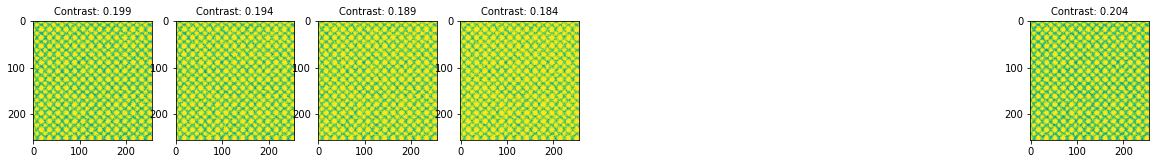

In [ ]:
px_size = 22.7
immat = loadmat('/content/drive/MyDrive/AtomfinderProject/Data/DiffContrast/simulate/direct/px22d7pm_000.mat')
framenoise = immat['frame_noise']
applycontrast(framenoise,77,79.5,0.5)

PSNR: 56.53 dB
PSNR: 45.9 dB
PSNR: 36.59 dB
PSNR: 28.44 dB
PSNR: 21.11 dB
PSNR: 14.48 dB
PSNR: 8.45 dB


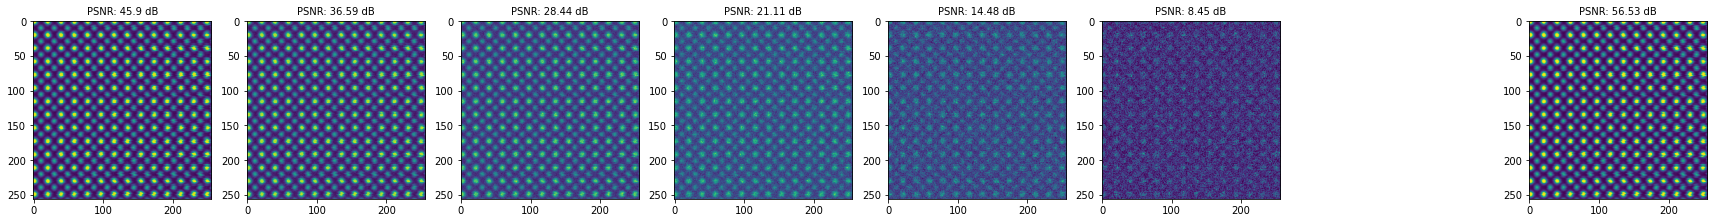

In [ ]:
source = np.load('/content/drive/My Drive/AtomfinderProject/Data/DiffPoisson/PSNR/NoPoisson/clear.npy')
applypoisson(source,30,64,5)

In [ ]:
# functions for generating contrast, poisson noise, resolution series

def applycontrast(ori, min, max, step):
        fig = plt.figure(figsize=(20,30))
        h, w = ori.shape[0:2]
        i = -1
        for factor in np.arange(min,max,step):
          background = factor*np.ones((h, w))
          new = np.clip(background+ori, a_min = 0, a_max = ori.max())
          contrast = (new.max()-new.min())/new.max()
          contrast = round(contrast,3)
          letters = '0d'+ str(int(1000*contrast))
          new = (map01(new) * 255).astype('uint8')
          im = Image.fromarray(new, 'L')
          os.mkdir('/content/drive/MyDrive/AtomfinderProject/Data/DiffContrast/simulate/direct/'+ letters +'/')
          im.save('/content/drive/MyDrive/AtomfinderProject/Data/DiffContrast/simulate/direct/'+ letters +'/'+ letters + '.tif')
          print("Contrast:",contrast)
          i = i+1
          ax = fig.add_subplot('18{}'.format(i))
          ax.imshow(new)
          ax.set_title('Contrast: {}'.format(contrast), fontsize=10)
        return new

# generate Poission noise series

def applypoisson(ori, min, max, step):
    ''' min >= 5, max <= 67'''
    # Add noise after rescale dataset to number of electrons
    def make_pnoise(image, l):
      vals = len(np.unique(image))
      vals = (50/l) ** np.ceil(np.log2(vals))
      image_n_filt = np.random.poisson(image * vals) / float(vals)
      return image_n_filt

    def psnr(truth, image):
      mse = np.mean( (truth - image) ** 2 )
      PIXEL_MAX = np.amax(truth)
      return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

    i = -1
    fig = plt.figure(figsize=(30,20))
    for factor in np.arange(min,max,step):
      img_noisy = make_pnoise(ori, factor)
      PSNR = psnr(ori, img_noisy)
      PSNR = round(PSNR, 2)
      print("PSNR:",PSNR,'dB')
      new = (map01(img_noisy) * 255).astype('uint8')
      im = Image.fromarray(new, 'L')
      letters = str(PSNR)
      [fron,back] = letters.split(".")
      letters = fron+'d'+ back
      #os.mkdir('/content/drive/My Drive/AtomfinderProject/Data/DiffPoisson/PSNR/'+ letters +'/')
      #im.save('/content/drive/My Drive/AtomfinderProject/Data/DiffPoisson/PSNR/'+ letters +'/'+ letters + '.tif')
      
      i = i+1
      ax = fig.add_subplot('18{}'.format(i))
      ax.imshow(new)
      ax.set_title('PSNR: {} dB'.format(PSNR), fontsize=10)

def applyblur(ori, min, max, step,px_size):
  
  def gaussKernel(sigma,imsize):
    x,y = np.meshgrid(range(1,imsize+1),range(1,imsize+1))
    x = x - imsize//2
    y = y - imsize//2
    tmp = -(x**2+y**2)/(2*sigma**2)
    return (1/(2*np.pi*sigma**2))*np.exp(tmp)
  
  int_max = np.amax(ori)
  int_min = np.amin(ori)
  fig = plt.figure(figsize=(20,30))
  i = -1

  for size in np.arange(min,max,step):
    sigma = (size/px_size)/(2.355)
    kernel = gaussKernel(sigma,ori.shape[0])
    fkernel = np.fft.fft2(kernel)
    sim_ss = np.fft.fftshift(np.fft.ifft2(fkernel*np.fft.fft2(ori))).real
    
    print("Souce size:",size,'pm')
    new = (map01(sim_ss) * 255).astype('uint8')
    im = Image.fromarray(new, 'L')
    letters = str(size)+'pm'
    os.mkdir('/content/drive/My Drive/AtomfinderProject/Data/DiffResolution/simulate/SourceSize/'+ letters +'/')
    im.save('/content/drive/My Drive/AtomfinderProject/Data/DiffResolution/simulate/SourceSize/'+ letters +'/'+ letters + '.tif')

    i = i+1
    ax = fig.add_subplot('18{}'.format(i))
    ax.imshow(sim_ss,clim = [int_min, int_max])
    ax.set_title('{0:0d}'.format(size) + ' pm', fontsize=14)


####Write csc metadata


In [ ]:
#Write medatada
import csv  
spath = '/content/drive/My Drive/AtomfinderProject/Data/WS2/Exp/DiffMag/15d47pm/'    
# field names  
fields = ['Material',	'Structure type',	'Space group' ,	
          'Zone axis',	'Dimension',	'Pixel size(pm) /Mag',
          'Contrast',	'Resolution(pm)',	'Dwel time(us)',	'Quality',	'Source','Precison(x/pm,y/pm)']  
    
# data rows of csv file  
'''rows = [ 'SrTiO3',  
        'Bulk' ,  
         'Pm3m [221]',  
         '100',  
         '1024 * 1024' ,
         '10.96' ,
         '0.595',
         '95.9',
         '6',
         'Good',
         'Jingrui exp','( 4.74 , 6.89 )']  
'''
rows = [ 'WS2',  
        'SL' ,  
         'P3m1 [164]',  
         '100',  
         '256 * 256' ,
         '15d47' ,
         '0.60',
         '95.4',
         '-',
         'Good',
         'Chenyu exp','-']          

    
# name of csv file  
filename = spath+"metadata.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  
        
    # writing the fields  
    csvwriter.writerow(fields)  
        
    # writing the data rows  
    csvwriter.writerow(rows)

#### Pack into hdf5

In [ ]:
## load data of a single image for example

rawimdata = loadmat('/content/drive/My Drive/AtomfinderProject/Data/DiffMag/simulate/px23d5pm/px23d5pm_000.mat')['frame_noise']
tif = np.asarray(Image.open('/content/drive/My Drive/AtomfinderProject/Data/DiffMag/simulate/px23d5pm/px23d5pm.tif'))
coordsx = np.load('/content/drive/My Drive/AtomfinderProject/Data/DiffMag/simulate/px23d5pm/Peaks_x.npy')
coordsy = np.load('/content/drive/My Drive/AtomfinderProject/Data/DiffMag/simulate/px23d5pm/Peaks_y.npy')
coords = np.vstack((coordsx,coordsy))

# Write a hdf5 file with hierarchical layers
f = h5py.File('dataset.hdf5', 'w')
STO = f.create_group("STO")
WS2H = f.create_group("WS2H")

Simu = STO.create_group("Simu")
Exp = STO.create_group("Exp")

pxsize = Simu.create_group("pxsize")
size01 = pxsize.create_group("size01")

rawim = size01.create_dataset('raw_img', data = rawimdata)
bit8im = size01.create_dataset('8bit_img', data = tif)
coordsxy = size01.create_dataset('CoordsXY', data = coords)

size01.attrs.create('pxsize',data = 25)
size01.attrs.create('contrast',data = 0.6)

NameError: ignored

In [ ]:
check = h5py.File('dataset.hdf5', 'r+')
descend_obj(check,sep='\t')
#os.remove('/content/dataset.hdf5')

	 - STO : <HDF5 group "/STO" (2 members)>
		 - Exp : <HDF5 group "/STO/Exp" (0 members)>
		 - Simu : <HDF5 group "/STO/Simu" (1 members)>
			 - pxsize : <HDF5 group "/STO/Simu/pxsize" (1 members)>
				 - size01 : <HDF5 group "/STO/Simu/pxsize/size01" (3 members)>
					 - 8bit_img : <HDF5 dataset "8bit_img": shape (256, 256), type "|u1">
					 - CoordsXY : <HDF5 dataset "CoordsXY": shape (2, 450), type "<f8">
					 - raw_img : <HDF5 dataset "raw_img": shape (256, 256), type "<f8">
	 - WS2H : <HDF5 group "/WS2H" (0 members)>


In [ ]:
def descend_obj(obj,sep='\t'):
    """
    Iterate through groups in a HDF5 file and prints the groups and datasets names and datasets attributes
    """
    if type(obj) in [h5py._hl.group.Group,h5py._hl.files.File]:
        for key in obj.keys():
            print (sep,'-',key,':',obj[key])
            descend_obj(obj[key],sep=sep+'\t')
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            print (sep+'\t','-',key,':',obj.attrs[key])

### Aux functions

In [ ]:
def peakfit(coordinates, im, path,size):
  # the accuracy of this output is dtpye64float
  peak_x_fit = []
  peak_y_fit = []
  egde_x = []
  egde_y = []
  for i in range(coordinates.shape[0]):

    x = int(coordinates[i][1])
    y = int(coordinates[i][0])
    if (y < size) or (y > (im.shape[0]-1-size)) or (x < size) or (x > (im.shape[0]-1-size)):
      egde_x.append(coordinates[i][1])
      egde_y.append(coordinates[i][0])
      continue

    patch = im[y-size:y+size, x-size:x+size]
    bg = np.amin(patch)  # minimum value within im
    guess = (bg, patch[size,size]-bg, size, size, (size-1)/2, (size-1)/2)
    bounds = ([min(0,bg), 0, 0, 0, 1, 1], [np.inf, np.inf, size*2, size*2, size*2-2, size*2-2])
#    print('bounds', bounds) 
#    print('guess', guess)
    param = fitGaussianx2(patch, guess, bounds)

    peak_x_fit.append(param[2]+x-size)
    peak_y_fit.append(param[3]+y-size)

  fig = plt.figure(figsize = (5,5))
  im0 = plt.imshow(im, cmap = plt.cm.gray)
  fig = colorbar(im0)
  plt.scatter(peak_x_fit, peak_y_fit,s = 1, c = 'b')


  plt.xticks([]) 
  plt.yticks([])

  peak_x_fit = np.asarray(peak_x_fit)
#  np.save(path+'Peaks_x.npy', np.asarray(peak_x_fit))
  peak_y_fit = np.asarray(peak_y_fit)
#  np.save(path+'Peaks_y.npy', np.asarray(peak_y_fit))  
  return peak_y_fit, peak_x_fit, egde_y, egde_x

def gaussianx2(xdata_tuple, bg, height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel() 

def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    ## Parameter here
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,verbose=0,maxfev=100000)
    return popt

In [ ]:
#calculate precision from coordinate

def FindPrecision(peaks_x,peaks_y,intensity,threshold,separation,est_spacing):
  '''
# Only effective if the Sr/Ti peak intensity is distinguishable 
# Refered to https://github.com/CY-Zhang/PyProcessingCodes/blob/master/JDDC/DoseTest_exp.ipynb
# Threshold: only atoms intensity above the threshold will be counted
# Separation: set to be half the atom radius in px, define range of points to calculate std deviation
# The remain atom grid should be tetragons. 
  '''
  peaks_int = []
  for i in range(len(peaks_x)):
    c= (int(peaks_y[i]),int(peaks_x[i]))
    peaks_int.append(float(intensity[c]))

  array_x = np.asarray(peaks_x)
  array_y = np.asarray(peaks_y)
  array_int = np.asarray(peaks_int)
  print('array_x',len(array_x),'array_y',len(array_y), 'array_int',len(array_int))
#
  index = np.where((array_x>50) & (array_x<1000) & (array_y > 50) & (array_y < 1000) & (array_int>0))
  array_x = array_x[index]
  array_y = array_y[index]
  array_int = array_int[index]
  print('After cut edge: array_x',len(array_x),'array_y',len(array_y), 'array_int',len(array_int))

  hist_bin = np.arange(np.amin(array_int),np.amax(array_int),2) #start,stop,step
  fig = plt.subplots(figsize=(6,2))
  plt.hist(array_int, bins=hist_bin)
  plt.title('Peak Intensity Histogram')

#     hist, bin_edges = np.histogram(array_int,bins=np.arange(np.amin(array_int)+0.5,np.amax(array_int),0.2), density=True)
#     threshold = bin_edges[argmin(hist)]
#  threshold = np.sort(array_int)[-5]
  print('Threshold',threshold)
  lattice1 = np.where(array_int>threshold)
  array_x1 = array_x[lattice1]
  array_y1 = array_y[lattice1]
  array_int1 = array_int[lattice1]
  print('After threshold: array_x',len(array_x1),'array_y',len(array_y1), 'array_int',len(array_int1))  
  fig = plt.subplots(figsize=(5,5))
  plt.scatter(array_x1,array_y1,s = 1)

  return FindXStd(array_x1,array_y1,separation,est_spacing), FindYStd(array_x1,array_y1,separation,est_spacing)

def FindYStd(array_x1_copy,array_y1_copy,separation,est_spacing):
    y_sep = []
    while array_x1_copy.size != 0:
        x_cor = array_x1_copy[0]
        index = np.where((array_x1_copy<x_cor+separation) & (array_x1_copy>x_cor-separation))
        array_y_sub = array_y1_copy[index]
        array_y_sub = np.sort(array_y_sub)
        for i in range(array_y_sub.shape[0]-1):
            spacing = array_y_sub[i+1] - array_y_sub[i]
            if (spacing < est_spacing + separation) & (spacing > est_spacing - separation):
                y_sep.append(spacing)
        array_x1_copy = np.delete(array_x1_copy,index)
        array_y1_copy = np.delete(array_y1_copy,index)
    print('Total counted y spacing number: ',len(y_sep))
    y_std = np.std(np.asarray(y_sep))
#     fig = plt.subplots(figsize=(6,2))
#     plt.hist(y_sep, bins='auto')
#     plt.title('Hist along y, std= '+str(y_std))
    return y_std


def FindXStd(array_x1_copy,array_y1_copy,separation,est_spacing):
    x_sep = []
    while array_x1_copy.size != 0:
        y_cor = array_y1_copy[0]
        index = np.where((array_y1_copy<y_cor+separation) & (array_y1_copy>y_cor-separation))
        array_x_sub = array_x1_copy[index]
        array_x_sub = np.sort(array_x_sub)
        for i in range(array_x_sub.shape[0]-1):
            spacing = array_x_sub[i+1] - array_x_sub[i]
            if (spacing < est_spacing + separation) & (spacing > est_spacing - separation):
                x_sep.append(array_x_sub[i+1] - array_x_sub[i])
        array_x1_copy = np.delete(array_x1_copy,index)
        array_y1_copy = np.delete(array_y1_copy,index)
    print('Total counted x spacing number: ',len(x_sep))
    x_std = np.std(np.asarray(x_sep))
#     fig = plt.subplots(figsize=(6,2))
#     plt.hist(x_sep, bins='auto')
#     plt.title('Hist along x, std= '+str(x_std))
    return x_std

In [ ]:
def rename_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            if name[-3:] =='png':
              new = root[-9:]
              os.rename(os.path.join(root,name),os.path.join(root,new[:9]+'.png'))

#rename_files('/content/drive/My Drive/AtomfinderProject/Data/Diffdistortion/flybackerror/')

In [ ]:
# rf for those functions above
'''
  def apply_gauss(img, value):
            """
            Random application of gaussian noise to image 
            min = 0 max = 50
            """
            h, w = img.shape[0:2]
            img_noisy = np.zeros((h, w))
            gauss_var = value
            img_ = random_noise(
                img, mode='gaussian', var=1e-4*gauss_var)
            img_noisy = img_
            return img_noisy


    def apply_poisson(img, value):
        """
        Random application of poisson noise to image
        min = 30 max = 40
        """
        def make_pnoise(image, l):
            vals = len(np.unique(image))
            vals = (50/l) ** np.ceil(np.log2(vals))
            image_n_filt = np.random.poisson(image * vals) / float(vals)
            return image_n_filt
        h, w = img.shape[0:2]
        img_noisy = np.zeros((h, w))
        poisson_l = value
        img_ = make_pnoise(img, poisson_l)
        img_noisy = img_
        img_noisy = img_noisy-img_noisy.min()
        img_noisy = (map01(img_noisy) * 255).astype('uint8')
        return img_noisy


    def apply_blur(img, value):
        """
        Guassian blurring of image 
        min = 1 max = 50
        """
        h, w = img.shape[0:2]
        img_noisy = np.zeros((h, w))
        blur_amount = value
        img_ = ndimage.filters.gaussian_filter(img, blur_amount*0.05)
        img_noisy = img_
        return img_noisy

    def apply_contrast(img, value):
        """
        Randomly change level of contrast of image
        min = 5 max = 20
        """
        h, w = img.shape[0:2]
        img_noisy = np.zeros((h, w))
        clevel = value
        img_ = exposure.adjust_gamma(img, clevel/10)
        img_noisy = img_
        return img_noisy


    def apply_background(img, factor):
        """
        Emulates thickness variation in STEM or height variation in STM
        
        """
        def gauss2d(xy, x0, y0, a, b, fwhm):
            return np.exp(-np.log(2)*(a*(xy[0]-x0)**2 + b*(xy[1]-y0)**2) / fwhm**2)
        h, w = img.shape[0:2]
        img_noisy = np.zeros((h, w))
        x, y = np.meshgrid(
            np.linspace(0, h, h), np.linspace(0, w, w), indexing='ij')
        x0 = np.random.randint(0, h - h // 4)
        y0 = np.random.randint(0, w - w // 4)
        a, b = np.random.randint(10, 20, 2) / 10
        fwhm = np.random.randint(min([h, w]) // 4, min([h, w]) - min([h, w]) // 2)
        Z = gauss2d([x, y], x0, y0, a, b, fwhm)
        ##img_ = img + factor * np.random.randint(-10, 10) * Z
        img_ = img + factor *10* Z
        img_noisy = img_
        img_noisy = img_noisy-img_noisy.min()
        img_noisy = (map01(img_noisy) * 255).astype('uint8')
        return img_noisy
